# Predictive Maintenance with Linear Regression (Streaming Data)

This notebook implements the full workflow:

1. **Develop regression models** – For each axis (#1–#8), fit univariate linear regression (Time → Axis values); record slope and intercept; plot scatter data with regression lines.
2. **Analyze residuals** – Compute observed minus prediction; plot distributions (scatter, line, or boxplots); look for outliers and patterns.
3. **Define thresholds** – Choose **MinC** (min current deviation for Alert), **MaxC** (max for Error), and **T** (min continuous time in seconds).
4. **Implement alert/error rules** – Alert: ≥ MinC kWh above regression line for ≥ T seconds continuously; Error: ≥ MaxC kWh above regression line for ≥ T seconds continuously.
5. **Produce testing data synthetically** – Use training metadata to generate synthetic test data and run predictions with the linear regression model.
6. **Visualize alerts/errors** – Overlay Alert/Error markers on regression plots; annotate each with its duration.
7. **Log results** – Store Alert and Error events in a structured CSV or database table.


### Load environment + test Neon connection

Load `.env` (e.g. `NEON_DATABASE_URL`) and verify connectivity to Neon PostgreSQL before loading training data.

In [1]:
import sys
print(sys.executable)


/Users/thanmayaanil/Desktop/Python/Predictive Maintenance_Lab1/venv/bin/python


In [2]:
from dotenv import load_dotenv
load_dotenv()

import sqlalchemy as sa
from database import get_database_url

engine = sa.create_engine(get_database_url())
with engine.connect() as conn:
    conn.execute(sa.text("SELECT 1"))

print("Connected to Neon")


Connected to Neon


### Load training data from Neon

Fetch trait measurements (axis #1–#8, timestamps) from the database for use as **training data** for the regression models.

In [3]:
import pandas as pd
from database import get_data_from_database

rows = get_data_from_database()

train_df = pd.DataFrame([{
    "trait": r.trait,
    "recorded_at": r.recorded_at,
    "axis_1": r.axis_1,
    "axis_2": r.axis_2,
    "axis_3": r.axis_3,
    "axis_4": r.axis_4,
    "axis_5": r.axis_5,
    "axis_6": r.axis_6,
    "axis_7": r.axis_7,
    "axis_8": r.axis_8,
} for r in rows])

train_df["recorded_at"] = pd.to_datetime(train_df["recorded_at"], utc=True, errors="coerce")
train_df = train_df.dropna(subset=["recorded_at"]).sort_values("recorded_at").reset_index(drop=True)

train_df.head(), train_df.shape


(     trait                      recorded_at  axis_1  axis_2  axis_3  axis_4  \
 0  current 2022-10-17 12:18:23.660000+00:00     0.0     0.0     0.0     0.0   
 1  current 2022-10-17 12:18:23.660000+00:00     0.0     0.0     0.0     0.0   
 2  current 2022-10-17 12:18:25.472000+00:00     0.0     0.0     0.0     0.0   
 3  current 2022-10-17 12:18:25.472000+00:00     0.0     0.0     0.0     0.0   
 4  current 2022-10-17 12:18:27.348000+00:00     0.0     0.0     0.0     0.0   
 
    axis_5  axis_6  axis_7  axis_8  
 0     0.0     0.0     0.0     0.0  
 1     0.0     0.0     0.0     0.0  
 2     0.0     0.0     0.0     0.0  
 3     0.0     0.0     0.0     0.0  
 4     0.0     0.0     0.0     0.0  ,
 (79344, 10))

### Convert time to seconds

Convert `recorded_at` to elapsed seconds from the first timestamp so we can fit **Time → Axis values** (univariate linear regression).

In [4]:
t0 = train_df["recorded_at"].min()
train_df["t_sec"] = (train_df["recorded_at"] - t0).dt.total_seconds()

train_df[["recorded_at", "t_sec"]].head()


,recorded_at,t_sec
0,2022-10-17 12:18:23.660000+00:00,0.000
1,2022-10-17 12:18:23.660000+00:00,0.000
2,2022-10-17 12:18:25.472000+00:00,1.812
3,2022-10-17 12:18:25.472000+00:00,1.812
4,2022-10-17 12:18:27.348000+00:00,3.688


## Develop regression models

For each axis (#1–#8), fit (train) a **univariate linear regression** (Time → Axis values) and produce a model able to make predictions when fed testing data.

- Record **slope** and **intercept** for each axis.
- (Next cell: plot scatter data with regression lines.)

In [5]:
import numpy as np

def fit_line(t, y):
    m, b = np.polyfit(t, y, 1)
    return float(m), float(b)

models = {}
for axis in range(1, 9):
    col = f"axis_{axis}"
    df_axis = train_df.dropna(subset=[col])
    t = df_axis["t_sec"].to_numpy()
    y = df_axis[col].to_numpy()
    models[axis] = fit_line(t, y)

models


{1: (-1.1767285669291457e-07, 0.7305420857437397),
 2: (2.1942034174284323e-06, 3.52388581901243),
 3: (-5.777185960382713e-07, 2.733897883456509),
 4: (3.890034464727757e-07, 0.6043568012838477),
 5: (8.381177886038322e-08, 0.9511027579170789),
 6: (4.744455471905516e-07, 0.5800773618963693),
 7: (5.537186154201738e-07, 0.8475626287465736),
 8: (8.499988745963473e-08, 0.09874786274985106)}

## Plot scatter data with regression lines

Plot scatter data (time vs axis value) with the fitted regression line overlaid for each axis (#1–#8).

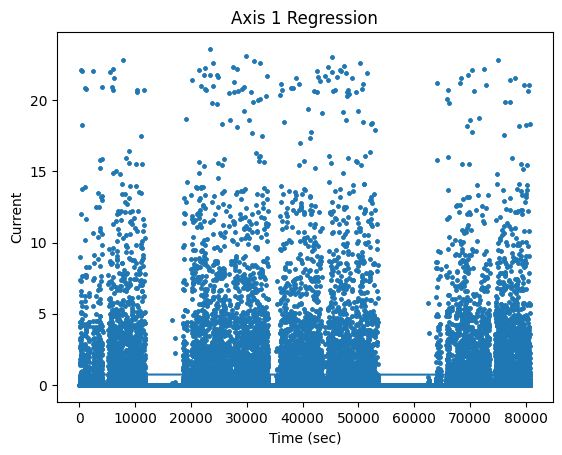

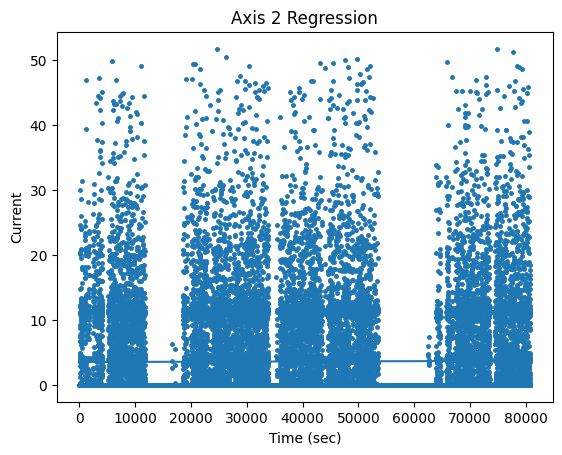

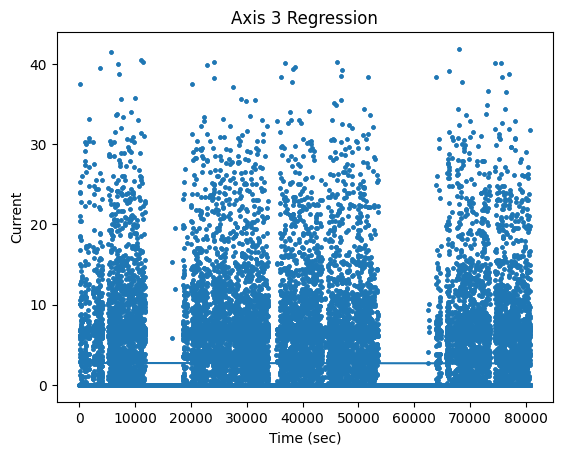

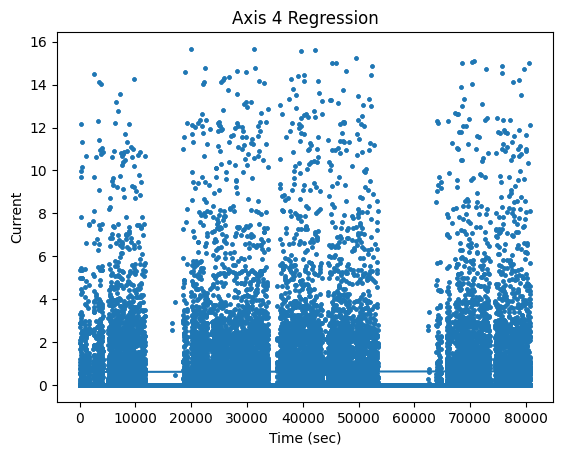

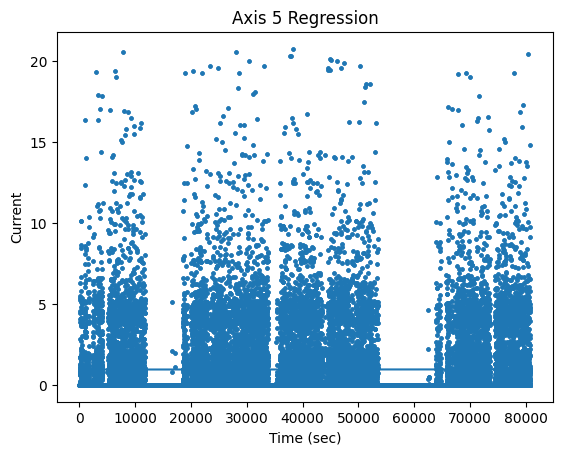

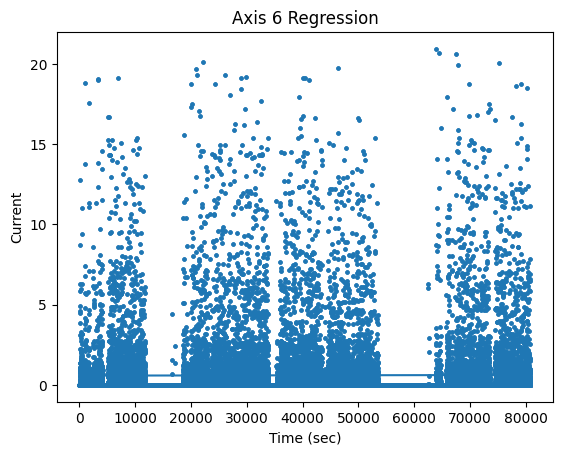

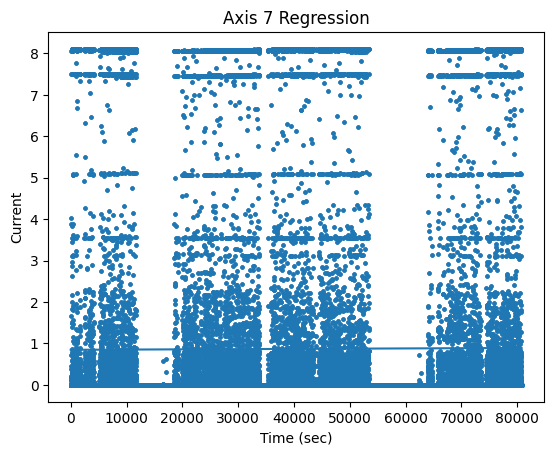

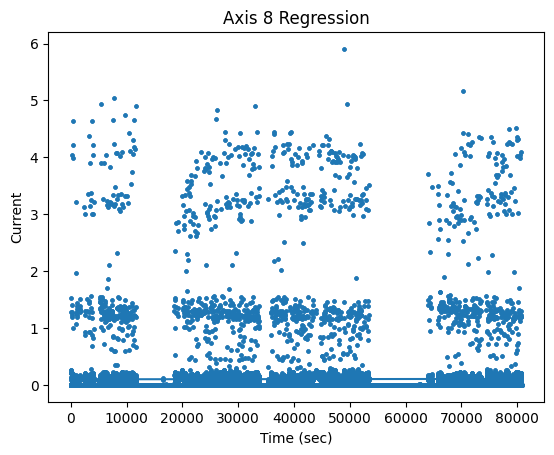

In [6]:
import matplotlib.pyplot as plt

def predict(m, b, t):
    return m*t + b

for axis in range(1, 9):
    col = f"axis_{axis}"
    df_axis = train_df.dropna(subset=[col])
    t = df_axis["t_sec"]
    y = df_axis[col]

    m, b = models[axis]
    yhat = predict(m, b, t)

    plt.figure()
    plt.scatter(t, y, s=5)
    plt.plot(t, yhat)
    plt.title(f"Axis {axis} Regression")
    plt.xlabel("Time (sec)")
    plt.ylabel("Current")
    plt.show()


## Analyze residuals

- Compute the **difference** between observed values and the regression prediction (residual = observed − predicted).
- (Next cell: plot distributions of residuals.)
- Look for **outliers** and **patterns** in the residual series.

In [7]:
residuals = {}

for axis in range(1, 9):
    col = f"axis_{axis}"
    df_axis = train_df.dropna(subset=[col]).copy()
    m, b = models[axis]
    df_axis["yhat"] = predict(m, b, df_axis["t_sec"])
    df_axis["resid"] = df_axis[col] - df_axis["yhat"]
    residuals[axis] = df_axis


Plot residuals

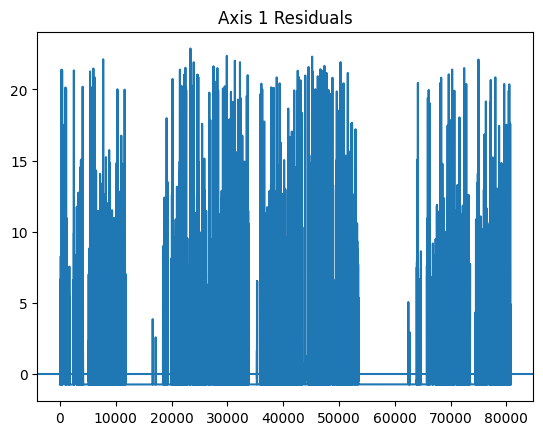

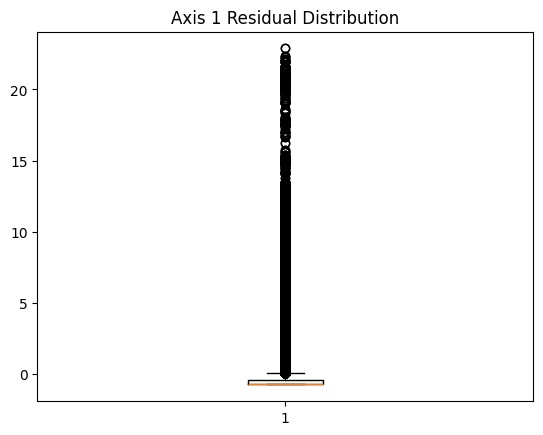

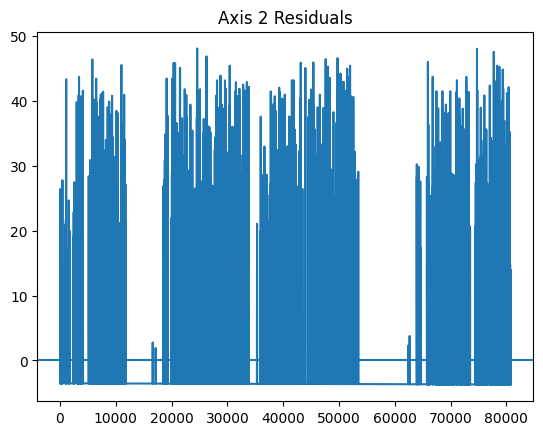

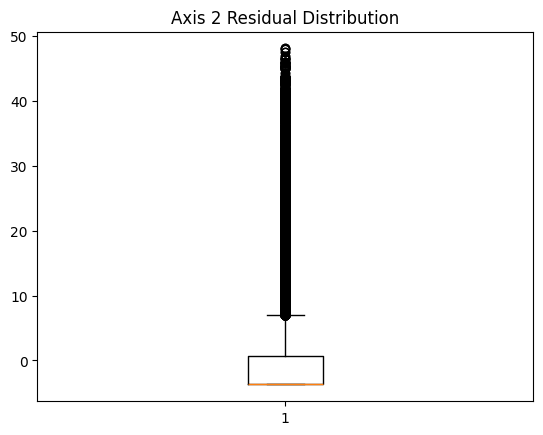

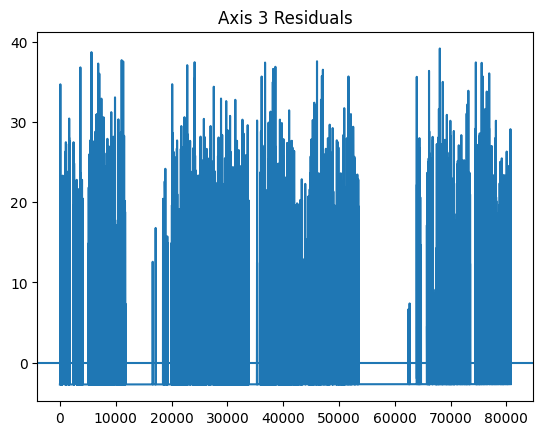

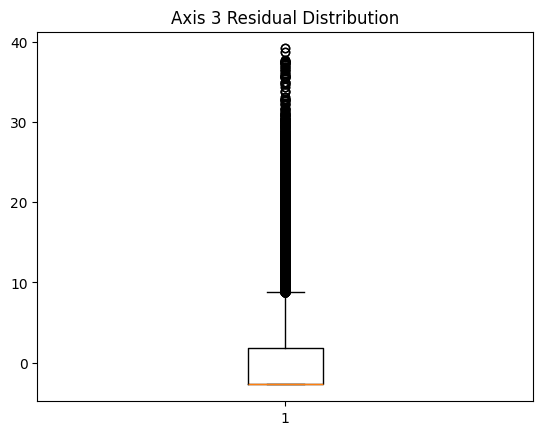

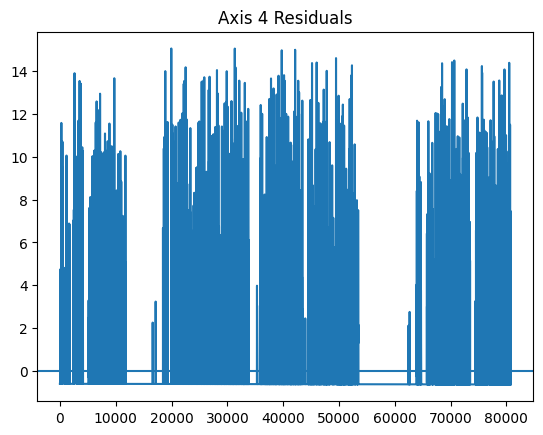

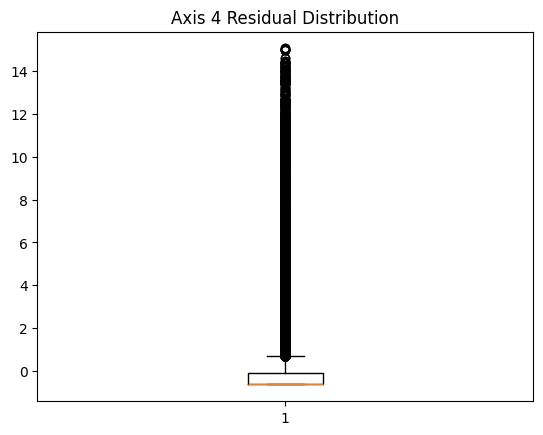

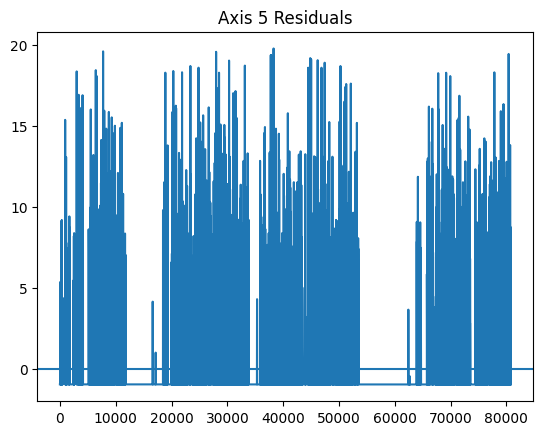

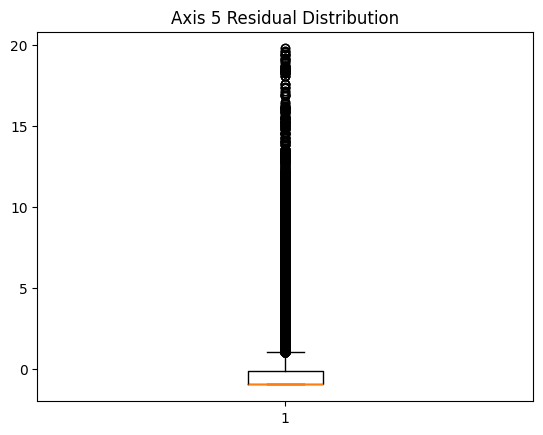

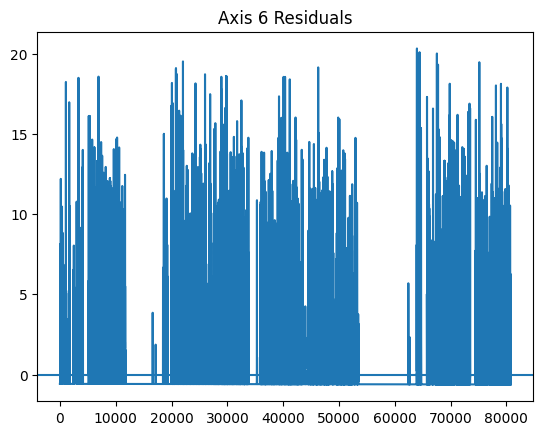

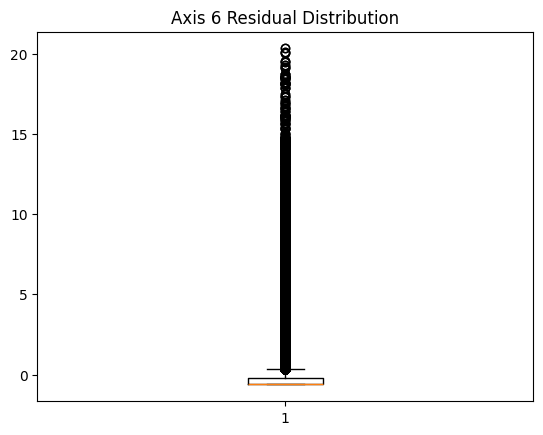

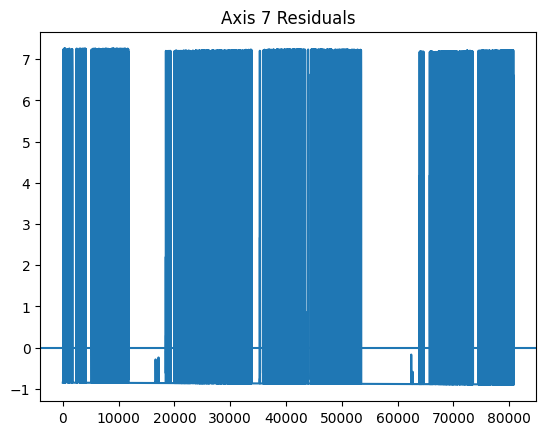

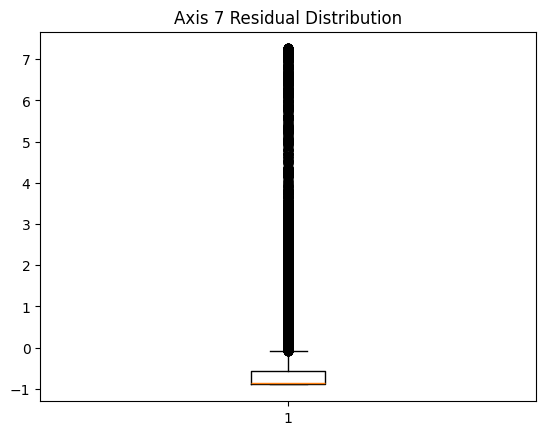

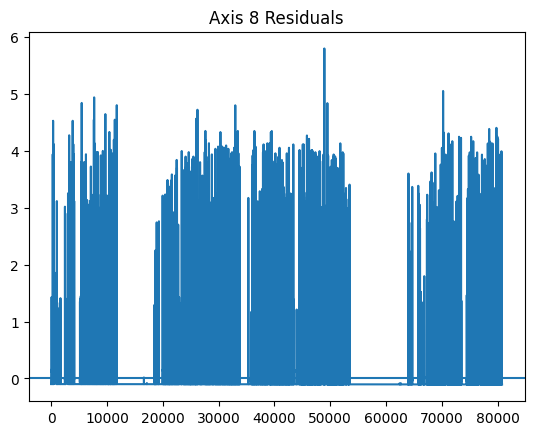

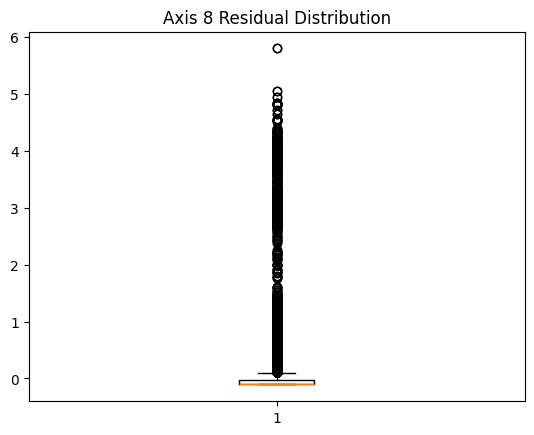

In [8]:
for axis in range(1, 9):
    df_r = residuals[axis]
    plt.figure()
    plt.plot(df_r["t_sec"], df_r["resid"])
    plt.axhline(0)
    plt.title(f"Axis {axis} Residuals")
    plt.show()

    plt.figure()
    plt.boxplot(df_r["resid"].dropna())
    plt.title(f"Axis {axis} Residual Distribution")
    plt.show()


## Define thresholds (per-axis)

From residual analysis, choose:

- **MinC** – The minimum current deviation (e.g. kWh above regression line) that should trigger an **Alert** if sustained.
- **MaxC** – The maximum current deviation (e.g. kWh above regression line) that should trigger an **Error** if sustained.
- **T** – The minimum continuous time (in seconds) that the deviation must persist.

(Next cell: choose global MinC, MaxC, T for all axes.)

In [9]:
thresholds = []
for axis in range(1, 9):
    pos = residuals[axis].loc[residuals[axis]["resid"] > 0, "resid"]
    MinC = pos.quantile(0.95)
    MaxC = pos.quantile(0.99)
    thresholds.append({"axis": axis, "MinC": MinC, "MaxC": MaxC})

threshold_df = pd.DataFrame(thresholds)
threshold_df


,axis,MinC,MaxC
0,1,11.345917,20.035358
1,2,24.568343,39.456644
2,3,19.660298,27.699218
3,4,7.206109,11.713910
4,5,8.517015,14.037762
5,6,9.469247,14.367856
6,7,7.232742,7.247426
7,8,3.136338,4.077780


## Choose global MinC, MaxC, T

Set global (or per-axis) **MinC**, **MaxC**, and **T** used by the alert/error rules:

- **Alert**: ≥ MinC kWh above regression line for ≥ T seconds continuously.
- **Error**: ≥ MaxC kWh above regression line for ≥ T seconds continuously.

In [10]:
MinC = threshold_df["MinC"].max()
MaxC = threshold_df["MaxC"].max()

dt = train_df["t_sec"].diff().dropna().median()
T = 10   # seconds

MinC, MaxC, dt, T


(np.float64(24.56834286225835),
 np.float64(39.45664445352793),
 np.float64(0.0),
 10)

## Produce testing data synthetically

Use the **training metadata** (e.g. time range, axis statistics) to **synthetically generate testing data** so we can run predictions using the linear regression model and test alert/error detection.

In [11]:
import random

def generate_synthetic(train_df, n_points=3000):
    df = pd.DataFrame()
    df["t_sec"] = np.arange(0, n_points)

    for axis in range(1, 9):
        col = f"axis_{axis}"
        mu = train_df[col].mean()
        sigma = train_df[col].std()
        df[col] = np.random.normal(mu, sigma, n_points)

    for _ in range(5):
        start = random.randint(0, n_points-200)
        axis = random.randint(1, 8)
        df.loc[start:start+100, f"axis_{axis}"] += MaxC*1.2

    return df

test_df = generate_synthetic(train_df)
test_df.to_csv("data/synthetic_test.csv", index=False)
test_df.head()


,t_sec,axis_1,axis_2,axis_3,axis_4,axis_5,axis_6,axis_7,axis_8
0,0,-0.136954,5.387787,-4.950614,1.241194,-0.218225,1.114068,4.164738,-0.728582
1,1,0.611883,-4.909712,8.401097,0.103994,2.292853,2.760480,3.089261,0.866388
2,2,-0.590441,-0.705285,3.248710,1.901345,1.074813,-1.274621,0.890459,-0.232797
3,3,5.164683,-16.505525,4.470372,-0.284086,0.063546,0.661608,-0.174787,-0.491932
4,4,0.538799,16.404537,-0.758484,1.592437,-0.640456,-1.089020,3.385899,0.049527


## Implement alert/error rules

Apply the rules on the (synthetic) stream:

- **Alert**: ≥ MinC kWh above regression line for ≥ T seconds **continuously**.
- **Error**: ≥ MaxC kWh above regression line for ≥ T seconds **continuously**.

Detect and collect Alert and Error events for visualization and logging.

In [12]:
def detect_events(df, axis, m, b, MinC, MaxC, T):
    col = f"axis_{axis}"
    events = []
    start_alert = None
    start_error = None

    for _, row in df.iterrows():
        t = row["t_sec"]
        y = row[col]
        resid = y - (m*t + b)

        if resid >= MinC:
            start_alert = start_alert or t
        else:
            start_alert = None

        if resid >= MaxC:
            start_error = start_error or t
        else:
            start_error = None

        if start_error and t-start_error >= T:
            events.append({"axis": axis, "type": "ERROR", "start": start_error, "end": t})
            start_error = None
        elif start_alert and t-start_alert >= T:
            events.append({"axis": axis, "type": "ALERT", "start": start_alert, "end": t})
            start_alert = None

    return events

events = []
for axis in range(1, 9):
    m, b = models[axis]
    events += detect_events(test_df, axis, m, b, MinC, MaxC, T)

events_df = pd.DataFrame(events)
events_df.to_csv("data/alerts_errors_log.csv", index=False)
events_df.head()


,axis,type,start,end
0,4,ERROR,1938.0,1948.0
1,4,ALERT,1938.0,1949.0
2,4,ERROR,1949.0,1959.0
3,4,ALERT,1950.0,1960.0
4,4,ERROR,1960.0,1970.0


## Visualize alerts/errors

- **Overlay** Alert/Error markers on your regression plots (e.g. time vs axis value with regression line).
- **Annotate** each marker with its **duration** (how long the deviation persisted).

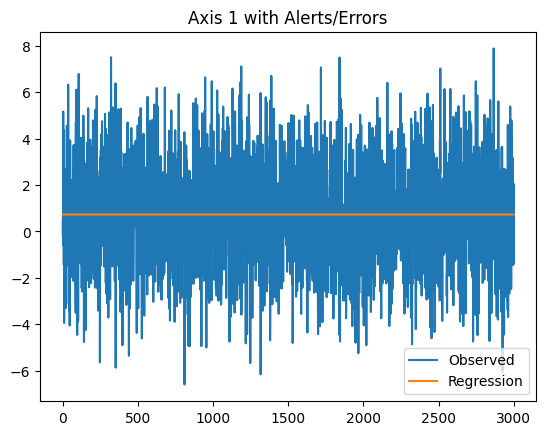

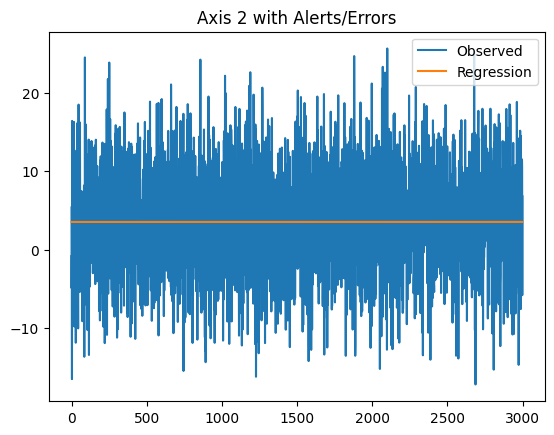

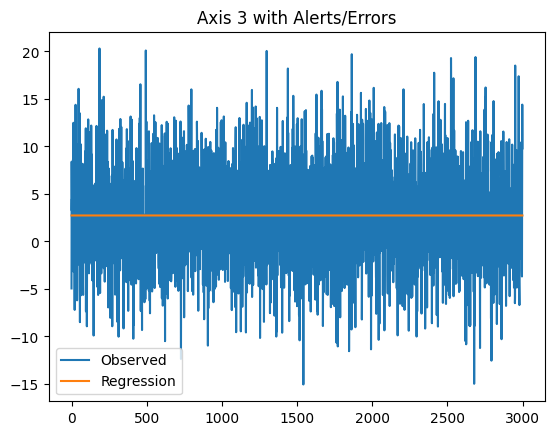

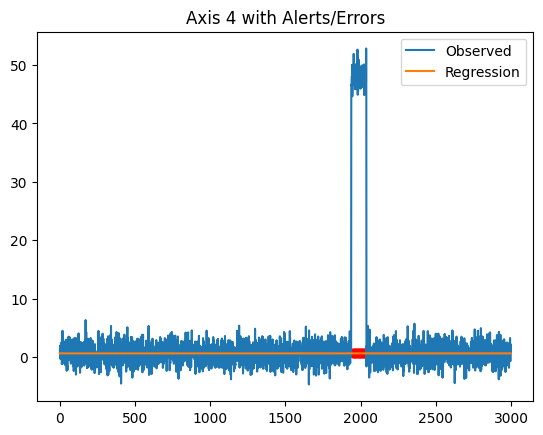

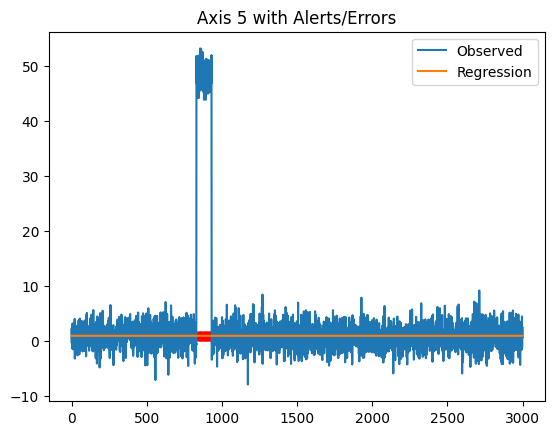

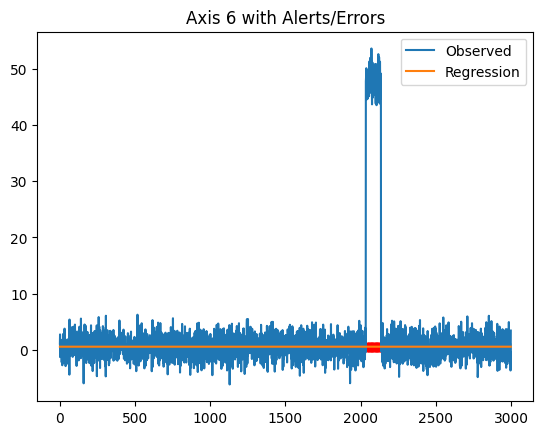

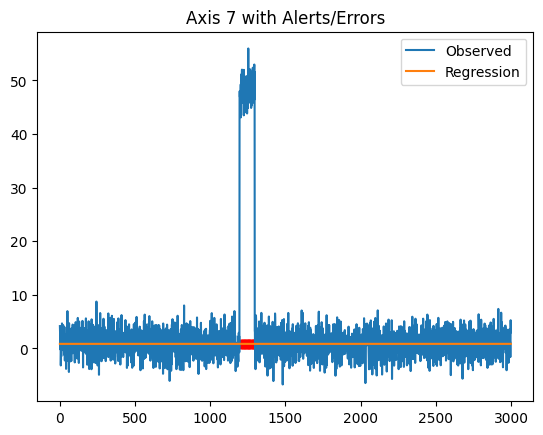

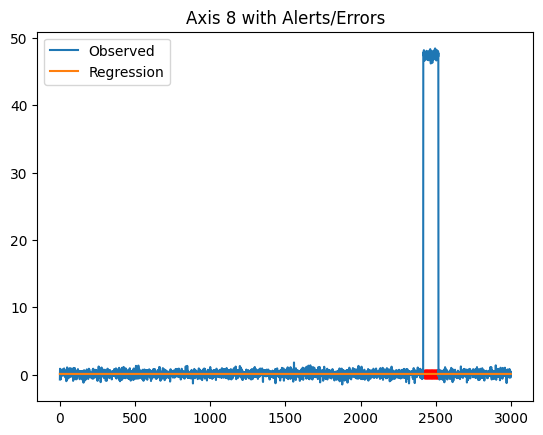

In [13]:
for axis in range(1, 9):
    m, b = models[axis]
    col = f"axis_{axis}"
    t = test_df["t_sec"]
    y = test_df[col]
    yhat = m*t + b

    plt.figure()
    plt.plot(t, y, label="Observed")
    plt.plot(t, yhat, label="Regression")

    ev = events_df[events_df["axis"] == axis]
    for _, e in ev.iterrows():
        plt.scatter(e["end"], m*e["end"]+b, color="red")

    plt.title(f"Axis {axis} with Alerts/Errors")
    plt.legend()
    plt.show()


## Log results

Store **Alert** and **Error** events in a **structured CSV or database table** (e.g. event type, axis, start time, end time, duration, deviation). The following cells create the table and insert events into Neon.

In [14]:
# Convert detected events to DataFrame
events_df = pd.DataFrame(events) 

# Save to CSV (LOG FILE)
log_path = "data/alerts_errors_log.csv"
events_df.to_csv(log_path, index=False)

print(f"Alert/Error events logged to: {log_path}")
events_df.head()



Alert/Error events logged to: data/alerts_errors_log.csv


,axis,type,start,end
0,4,ERROR,1938.0,1948.0
1,4,ALERT,1938.0,1949.0
2,4,ERROR,1949.0,1959.0
3,4,ALERT,1950.0,1960.0
4,4,ERROR,1960.0,1970.0


### Create table (for logging events)

Create the database table used to store Alert and Error events (e.g. event type, axis, start/end time, duration).

In [18]:
import sqlalchemy as sa
from database import get_database_url

engine = sa.create_engine(get_database_url())

with engine.begin() as conn:
    conn.execute(sa.text("""
        CREATE TABLE IF NOT EXISTS alert_error_events (
            id SERIAL PRIMARY KEY,
            axis INTEGER,
            type TEXT,
            start_t FLOAT,
            end_t FLOAT,
            duration_sec FLOAT
        );
    """))

print("alert_error_events table ready")


alert_error_events table ready


### Insert events into Neon

Persist the detected Alert and Error events into the Neon database (or write to CSV) for audit and downstream analysis.

In [19]:
events_df.to_sql(
    "alert_error_events",
    engine,
    if_exists="replace", 
    index=False
)

print("Alert/Error events stored in Neon database")


Alert/Error events stored in Neon database
